# (1.1) Load Datasets

In [1]:
from nltk import word_tokenize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
import nltk

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
np.set_printoptions(threshold=np.inf)

In [23]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
ModelEmbed = namedtuple('ModelEmbed', 'type, name, dimension, corpus, model')

In [3]:
from nltk import word_tokenize

columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]

def load_df(path, d_type, header):
    df = pd.read_csv(path, header=header, sep = "\t")
    if len(df.columns) == len(columns):
        df.columns = columns
    if d_type == 'word':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))<=1,]
    elif d_type == 'phrase':
        df = df.loc[df.target.map(lambda target : len(word_tokenize(target)))>1,]
    return df

def load_datasets(names, train_name, test_name, type_train = None, type_test = None, header=None):
    MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
    datasets = [Dataset(name, load_df(MAIN_PATH_DATASET + name + '_' + train_name + '.tsv', type_train, header),
                              load_df(MAIN_PATH_DATASET + name + '_' + test_name + '.tsv', type_test, header))
                              for name in names]
    return datasets

# (1.2) Load Embedding Models

In [24]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

def get_embedding_models():
    glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
                  #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
                  Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None)] 
                  #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
                  #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
                  #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
                  #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
                 #Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None),
                  #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None),
                  #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

    models = []
    for model in glove_defs:
        glove_file = datapath(MAIN_PATH + model.name)
        tmp_file = get_tmpfile(model.name + '-temp')
        glove2word2vec(glove_file, tmp_file)
        vecs = KeyedVectors.load_word2vec_format(tmp_file)
        models.append(ModelEmbed(model.type, model.name, model.dimension, model.corpus, vecs))
        print('load model : {}'.format(model.name))
    return models

# (2.1) Preprocessing
Here we present all the code to preprocess the data stored in a dataframe into a proper representation that can be used in sequence tagging models.

In [5]:
from nltk import word_tokenize
from nltk.stem.wordnet import *
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys
from collections import Counter
from ngram_representation import missing_strat_random
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


wordNetLemmatizer = WordNetLemmatizer()

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def targets_with_index(start, end, context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    vals = [(target[0], target[1]) for target in targets \
            if overlaps(start, end, target[2], target[3])]
    return [val for val in vals if val[0] != '"']

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    '''
    Receives a sentence denoted by context and applies tokenization
    on the input. Each token is annotated with its word index starting
    from 1 and the corresponding start and end character positions of 
    the word. Also applies some strategies to handle unproper formated
    input sentence string such as removing additional whitespaces and 
    quotation marks that otherwise change the actual character start
    and end positions. All results are cached in case it has to be computed
    multiple times for the same sentence.
    '''
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

@lru_cache(maxsize=None)
def wordnet_pos_tagging(sentence):
    tokens = word_tokenize(sentence)
    return nltk.pos_tag(tokens)

def pos_tags(start, end, sentence):
    wordPOSPairs = wordnet_pos_tagging(sentence)
    targets_index = targets_with_index(start, end, sentence)
    results = [wordPOSPairs[tpl[1]-1][1] for tpl in targets_index]
    filtered_results = [result for result in results 
                        if remove_punctuation(result).strip() and result != 'POS']
    return filtered_results if len(filtered_results) > 0 else None

def wordnet_lemma(target, pos):
    tokens = nltk.word_tokenize(target)
    if pos:
        pos = [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos]
        lemmas = [wordNetLemmatizer.lemmatize(token, poss)
                     for token, poss in zip(tokens, pos)]
        return ' '.join(lemmas)
    return target

def preprocessing(dataframe):
    df = dataframe.copy()
    df['sentence'] = df.sentence.apply(lambda sent : sent.replace("''", "``"))
    df['p_target'] = df.target.apply(lambda target : target.strip().lower())
    df['pos_tags'] = df[['start', 'end', 'sentence']].apply(lambda vals : pos_tags(*vals), axis = 1)
    df['pos_tags_pt'] = df.pos_tags.apply(lambda pos : [penn_to_wn(poss) if penn_to_wn(poss) else 'n' for poss in pos] 
                                          if pos else [])
    df['lemma'] = df[['target', 'pos_tags']].apply(lambda vals : wordnet_lemma(*vals), axis = 1)
    df['p_lemma'] = df.lemma.apply(lambda lemma : lemma.strip().lower())
    return df

def build_vocabulary(sentences, embedding, dimension, 
                     missing='unique', provided = ['s_target', 'e_target']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a vocabulary of the words contained
    and assigns unique indicies to the words. In particular, it returns 
    a map of indices to their words, a map of words to their indices
    and based on the provided embedding model an embedding matrix
    for the constructed vocabulary. For missing vocabulary, it 
    constructs a random embedding and a proper index is missing parameter
    is set to 'unique', otherwise if it is set to 'equal' it creates
    a random embedding for one special UNK embedding and neglects missing
    vocabulary in the built index. All tokens in the 'provided' list,
    receive under 'equal' mode still individual random embeddings.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_words = [word for sentence in sentences for word in sentence]
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    index = 1
    word2index = {}
    for (word, count) in counter.most_common():
        if (missing=='unique' or word in embedding.vocab):
            word2index[word] = index
            index += 1
    word2index['_pad_'] = 0
    if missing == 'equal':
        word2index['_unk_'] = len(word2index)
        for token in provided:
            word2index[token] = len(word2index)
    index2word = {index : word for word, index in word2index.items()}
    vocab_size = len(word2index)
    print('# Vocab : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_words = []
    for word, index in word2index.items():
        if word in embedding.vocab:
            embedding_matrix[index] = embedding[word]
        else:
            embedding_matrix[index] = missing_strat_random(word, dimension)
            missing_embed_words.append(word)
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return word2index, index2word, embedding_matrix


def build_char_vocabulary(sentences, embedding, dimension, 
                          missing='unique', provided = ['_']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a character vocabulary and provides
    a mapping of unique indices to the found characters, a mapping of
    the characters to their indicies and a character embedding matrix
    where the i-th row represents the character embedding of the character
    with index i. This is based on a provided character embedding, represented
    as a dictionary. Provided tokens will be added as a single char to
    the vocabulary.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_chars = [char for sentence in sentences 
                 for word in sentence for char in word]
    all_chars.extend(provided)
    print('# Chars : {}'.format(len(all_chars)))
    counter = Counter(all_chars)
    index = 1
    char2index = {}
    for (char, count) in counter.most_common():
        if (missing=='unique' or char in embedding.keys()):
            char2index[char] = index
            index += 1
    char2index['_pad_'] = 0
    if missing == 'equal':
        char2index['_unk_'] = len(char2index)
    index2char = {index : char for char, index in char2index.items()}
    vocab_size = len(char2index)
    print('# Vocab (chars) : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_chars = []
    for char, index in char2index.items():
        if char in embedding.keys():
            embedding_matrix[index] = embedding[char]
        else:
            embedding_matrix[index] = missing_strat_random(char, dimension)
            missing_embed_chars.append(char)
    missing_embed_count = len(missing_embed_chars)
    print('# Chars missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return char2index, index2char, embedding_matrix


def compute_character_embeddings(embedding):
    '''
    Computes a character embedding as a dictionary of word to its
    embedding based on a gensim word embedding. For each character,
    averages the word embeddings containing the character as an
    approximation to character-level embeddings.
    '''
    chars = {}
    for word, vocab in embedding.vocab.items():
        vector = embedding[word]
        for char in word:
            if ord(char)<128:
                if char in chars:
                    chars[char] = (chars[char][0]+vector, 
                                   chars[char][1]+1)
                else:
                    chars[char] = (vector, 1)
    for char, (vector, num) in chars.items():
        chars[char] = np.round(vector/num, 6).tolist()
    return chars

def forward_transformation_v1(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. For each sentence in the
    dataset, returns the sentence id, the sentence as a list of 
    words based on tokenization, the binary label for each word, 
    the probability label for each word and a list of (start, end)
    tuples representing the start and end positions of the words 
    in the sentence word list. This can be used to map back the
    predictions later. This function should be used if classification
    is done on word level.
    '''
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentence_ids = []
    sentences = []
    binaries = []
    probabilities = []
    start_ends = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentence_ids.append(sent_id)
        sentences.append([vals[0] for vals in sent_repr])
        binaries.append([vals[3] for vals in sent_repr])
        probabilities.append([vals[4] for vals in sent_repr])
        start_ends.append([(vals[1], vals[2]) for vals in sent_repr])
    return sentence_ids, sentences, start_ends, binaries, probabilities


def forward_transformation_v2(dataframe, start_tag = 's_target', end_tag = 'e_target',
                                   lowercase = True, filter_punc = True, filtering = "a132"):
    '''
    Transforms the provided dataframe rows into a representation
    to be used in a sequence classifier. Here, each row in the dataframe
    is transformed into one instance to classify and each target in a 
    sentence is tagged by surrounding it with the provided start and
    end tag. Hence, the whole sequence is classified at once. Returns
    the transformed sentences (one for each row in the dataframe), the
    corresponding binary and probabilitiy label.
    '''
    sentences = []
    binaries = []
    probabilities = []
    for index, row in dataframe.iterrows():
        sentence = row['sentence']
        start = row['start']
        end = row['end']
        sentence = sentence[:start] + start_tag + ' ' + sentence[start:end] + \
                             ' ' + end_tag + sentence[end:]
        if lowercase:
            sentence = sentence.lower()
        sent_repr = all_tokens_with_index(sentence)
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append([word for word, index, start, end in sent_repr])
        binaries.append(row['binary'])
        probabilities.append(row['prob'])
    return sentences, binaries, probabilities


def merge_train_test_dataset(dataset):
    '''
    Computes the training and test set size as (1) the
    number of rows and (2) the number of unique sentences
    contained. Merges the training and test set and
    computes the same values for the merged dataframe.
    This can be used before creating the vocabulary,
    to also not miss vocabulary contained solely in the
    test set. Before training, the dataset has to be split
    up again based on the provided numbers.
    '''
    # Compute num rows and sents for train and test
    train_num_rows = dataset.train.shape[0]
    train_num_sents = len(list(set(dataset.train.sentence.values.tolist())))
    test_num_rows = dataset.test.shape[0]
    test_num_sents = len(list(set(dataset.test.sentence.values.tolist())))
    # Merge dataframes and compute same values
    dataset_merged = dataset.train.append(dataset.test)
    dataset_merged['sent_id'] = dataset_merged.groupby('sentence').ngroup()
    dataset_num_rows = dataset_merged.shape[0]
    dataset_num_sents = len(list(set(dataset_merged.sentence.values.tolist())))
    print('----------------------')
    print('# Rows train : {}'.format(train_num_rows))
    print('# Rows test : {}'.format(test_num_rows))
    print('# Rows dataset : {}'.format(dataset_num_rows))
    print('----------------------')
    print('# Sents train : {}'.format(train_num_sents))
    print('# Sents test : {}'.format(test_num_sents))
    print('# Sents dataset : {}'.format(dataset_num_sents))
    print('----------------------')
    return dataset_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents
        
def split_train_test_dataset(dataset, index):
    '''
    Splits the given dataset (here the list of sentences represented
    as list of words, binary label lists etc.) into train and test
    based on the given index. Depending on the used sequence representation
    (v1 or v2), the index should be either the number of training sentences 
    (unique) or the number of training rows.
    '''
    train = dataset[:index]
    test = dataset[index:]
    print('Training set length : {}'.format(len(train)))
    print('Test set length : {}'.format(len(test)))
    return train, test
        
def sentence_max_length(sentences):
    sent_lens = [len(sentence) for sentence in sentences]
    sent_max_length = np.max(sent_lens)
    print('Max length sentence : {}'.format(sent_max_length))
    return sent_max_length

def pad_encode_sequences(sentences, word2index, missing, max_length):
    '''
    Encodes a list of sentences (a sentence represented as a list of words)
    into their corresponding integer index based on the provided dictionary.
    For missing tokens in the dictionary, applies the provided 'missing' value.
    Afterwards, applies padding to the sentences and uses 'max_length' as the
    maximum overall sentence length.
    '''
    words_with_indices = [[word2index.get(word, missing)
                        for word in sent] for sent in sentences]
    pad_val = word2index['_pad_']
    return pad_sequences(maxlen=max_length, \
            sequences=words_with_indices, padding="post", value=pad_val)

def pad_binaries_probs(binaries, probabilities, max_length):
    '''
    Applies padding to binary labels and the probabilities.
    Parameter 'max_length' is used as the maximum length
    to pad the two provided lists to.
    '''
    binary_padded = pad_sequences(maxlen=max_length, sequences=binaries, padding="post", value=0)
    prob_padded = pad_sequences(maxlen=max_length, sequences=probabilities, padding="post", value=0, dtype="float")
    return binary_padded, prob_padded

def pad_chars(sentences, char2index, sent_max_length, char_max_length):
    words_as_chars_indices = []
    for sent in sentences:
        sent_repr = []
        for sent_index in range(sent_max_length):
            words_repr = []
            for word_index in range(char_max_length):
                try:
                    words_repr.append(char2index[sent[sent_index][word_index]])
                except:
                    words_repr.append(char2index.get('_pad_'))
            sent_repr.append(words_repr)
        words_as_chars_indices.append(sent_repr)
    return words_as_chars_indices

def ngram_prediction_agg_majority_vote(predictions):
    positive_sum = np.sum(predictions)
    ratio = positive_sum / len(predictions)
    return int(ratio + 0.5)

def ngram_prediction_agg_max(predictions):
    return np.max(predictions)

def ngram_prediction_agg_begin(predictions):
    return predictions[0]

def ngram_prediction_agg_end(predictions):
    return predictions[-1]

def backward_transformation_v1(dataset, sent_ids, test_words_padded, 
                    index2word, test_start_end, final_predictions):
    '''
    Based on the dataset, the list of sentence_ids, the padded words
    from the test set, the start and end tuple list of the test set and
    the produced v1 predictions, maps the predictions back to original
    representation (from number of sentences to number of rows) and
    computes the F1-score between predictions and labels of the orignal
    representation. For n-gram targets, applies an aggregation strategy.
    '''
    ngram_prediction_agg = ngram_prediction_agg_max
    results = []
    num_missing_match = []
    all_predictions = []
    all_labels = []
    count=0
    sent_count = 0
    for ind, sent in enumerate(test_words_padded):
        sent_id = sent_ids[ind]
        ses = test_start_end[ind]
        preds = final_predictions[ind]
        selected = dataset.loc[dataset.sent_id==sent_id,]
        targets = selected.target.values.tolist()
        start_ends = list(zip(selected.start.values.tolist(), selected.end.values.tolist()))
        binary_y = selected.binary.values.tolist()
        for label_index, (start, end) in enumerate(start_ends):
            matching_indices = [i for i, (s, e) in enumerate(ses) if overlaps(start, end, s, e)]
            if not matching_indices:
                num_missing_match.append((sent_id, (start,end), ses, sent))
                prediction = 1
            matching_predictions = [preds[i] for i in matching_indices]
            if len(matching_predictions)>1:
                prediction = ngram_prediction_agg(matching_predictions)
            else:
                if matching_indices:
                    prediction = matching_predictions[0]
            matching_labels = binary_y[label_index]
            all_labels.append(matching_labels)
            all_predictions.append(prediction)
    f1 = f1_score(all_labels, all_predictions)
    return f1

C:\Users\Studio\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def preprocess_datasets(datasets):
    return [Dataset(ds.name, preprocessing(ds.train), 
                             preprocessing(ds.test)) 
                             for ds in datasets]

# (2.2) DL Models

## (2.2.1) Utility Methods

Here we define some Keras Metric classes, in order to introduce some custom metrics during training. Basically, we employ F1 and compute the F1 on the training and on the validation set after each epoch.

In [126]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import keras.callbacks

class MetricsV2(keras.callbacks.Callback):
    def __init__(self, training_data, show_test_data=True):
        self.train_scores = []
        self.test_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = np.argmax(test_predict, axis = 1)
        test_scores = precision_recall_fscore_support(test_label, test_predict)
        self.test_scores.append(test_scores)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = np.argmax(train_predict, axis = 1)
        train_scores = precision_recall_fscore_support(train_label, train_predict)
        self.train_scores.append(train_scores)
        print('Training P : {}, R : {}, F1 : {}'.format(train_scores[0][1], \
                                train_scores[1][1], train_scores[2][1]))
        print('Testing P : {}, R : {}, F1 : {}'.format(test_scores[0][1], \
                                test_scores[1][1], test_scores[2][1]))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
    
class MetricsV1(keras.callbacks.Callback):
    
    def __init__(self, training_data, show_test_data=True):
        self.train_scores = []
        self.test_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        test_label = test_label.reshape((test_shape[0]*test_shape[1], test_shape[2]))
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict(self.validation_data[0]))
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]), test_shape[2])
        test_predict = np.argmax(test_predict, axis = 1)
        test_scores = precision_recall_fscore_support(test_label, test_predict)
        self.test_scores.append(test_scores)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1], train_shape[2]))
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]), train_shape[2])
        train_predict = np.argmax(train_predict, axis = 1)
        train_scores = precision_recall_fscore_support(train_label, train_predict)
        self.train_scores.append(train_scores)
        print('Training P : {}, R : {}, F1 : {}'.format(train_scores[0][1], \
                                train_scores[1][1], train_scores[2][1]))
        print('Testing P : {}, R : {}, F1 : {}'.format(test_scores[0][1], \
                                test_scores[1][1], test_scores[2][1]))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
            
class MetricsV1Char(keras.callbacks.Callback):
    
    def __init__(self, training_data, show_test_data=True):
        self.train_scores = []
        self.test_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[2]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        test_label = test_label.reshape((test_shape[0]*test_shape[1], test_shape[2]))
        test_label = np.argmax(test_label, axis = 1)
        test_predict = np.asarray(self.model.predict([self.validation_data[0], self.validation_data[1]]))
        print(test_predict.shape)
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]), test_shape[2])
        test_predict = np.argmax(test_predict, axis = 1)
        test_scores = precision_recall_fscore_support(test_label, test_predict)
        self.test_scores.append(test_scores)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1], train_shape[2]))
        train_label = np.argmax(train_label, axis = 1)
        train_predict = np.asarray(self.model.predict(self.training_data[0]))
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]), train_shape[2])
        train_predict = np.argmax(train_predict, axis = 1)
        train_scores = precision_recall_fscore_support(train_label, train_predict)
        self.train_scores.append(train_scores)
        print('Training P : {}, R : {}, F1 : {}'.format(train_scores[0][1], \
                                train_scores[1][1], train_scores[2][1]))
        print('Testing P : {}, R : {}, F1 : {}'.format(test_scores[0][1], \
                                test_scores[1][1], test_scores[2][1]))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
            

class MetricsElmoV1(keras.callbacks.Callback):
    '''
    Make sure to use 'sparse_categorical_crossentropy' as the loss function.
    '''
    
    def __init__(self, training_data, batch_size, show_test_data=True):
        self.train_scores = []
        self.test_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[1]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        print('ELMo Metric Test Prediction')
        print(test_label.shape)
        test_label = test_label.reshape((test_shape[0]*test_shape[1]))
        test_predict = prediction_elmo_model(self.validation_data[0], self.model, self.batch_size)
        print(test_predict.shape)
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]))
        test_scores = precision_recall_fscore_support(test_label, test_predict)
        self.test_scores.append(test_scores)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        train_label = train_label.reshape((train_shape[0]*train_shape[1]))
        print('ELMo Metric Training Prediction')
        train_predict = prediction_elmo_model(self.training_data[0], self.model, self.batch_size)
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]))
        train_scores = precision_recall_fscore_support(train_label, train_predict)
        self.train_scores.append(train_scores)
        print('Training P : {}, R : {}, F1 : {}'.format(train_scores[0][1], \
                                train_scores[1][1], train_scores[2][1]))
        print('Testing P : {}, R : {}, F1 : {}'.format(test_scores[0][1], \
                                test_scores[1][1], test_scores[2][1]))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)
            
class MetricsElmoWembedsV1(keras.callbacks.Callback):
    '''
    Make sure to use 'sparse_categorical_crossentropy' as the loss function.
    '''
    
    def __init__(self, training_data, batch_size, show_test_data=True):
        self.train_scores = []
        self.test_scores = []
        self.training_data = training_data
        self.show_test_data = show_test_data
        self.batch_size = batch_size
        
    def on_epoch_end(self, batch, logs={}):
        # Compute the F1-score for the test data
        test_label = self.validation_data[2]
        test_label = np.array(test_label)
        test_shape = test_label.shape
        print('ELMo Metric Test Prediction')
        print(test_label.shape)
        test_label = test_label.reshape((test_shape[0]*test_shape[1]))
        print(test_label.shape)
        print(np.array(self.validation_data).shape)
        test_predict = prediction_elmo_wembeds_model([self.validation_data[0], 
                                    self.validation_data[1]], self.model, self.batch_size)
        print('Test predictions')
        print(test_predict.shape)
        test_predict = test_predict.reshape((test_shape[0]*test_shape[1]))
        print('shape test predict {}'.format(test_predict.shape))
        print('shape test label {}'.format(len(test_label)))
        test_scores = precision_recall_fscore_support(test_label, test_predict)
        self.test_scores.append(test_scores)
        # Compute the F1-score for the training data
        train_label = self.training_data[1]
        train_label = np.array(train_label)
        train_shape = train_label.shape
        print('training : {}'.format(train_shape))
        train_label = train_label.reshape((train_shape[0]*train_shape[1]))
        print('ELMo Metric Training Prediction')
        train_predict = prediction_elmo_wembeds_model(self.training_data[0], self.model, self.batch_size)
        train_predict = train_predict.reshape((train_shape[0]*train_shape[1]))
        train_scores = precision_recall_fscore_support(train_label, train_predict)
        self.train_scores.append(train_scores)
        print('Training P : {}, R : {}, F1 : {}'.format(train_scores[0][1], \
                                train_scores[1][1], train_scores[2][1]))
        print('Testing P : {}, R : {}, F1 : {}'.format(test_scores[0][1], \
                                test_scores[1][1], test_scores[2][1]))
        if self.show_test_data:
            print('--------------------Targets-------------------------')
            print(test_label)
            print('--------------------Predictions-------------------------')
            print(test_predict)

The ELMo based models require the prediction to use the same batch size as in training. This function computes predictions based on the provided batch size and handles test sets which sizes are not divisible by the batch size without a remaining part.

In [120]:
def prediction_elmo_model(data, model, batch_size):
    '''
    Returns the predictions of an ELMo Keras model for the
    provided data and batch_size. If required, extends the
    data to make it divisible by batch_size in order to
    work with the ELMo model and cuts of the extension.
    Creates predictions iteratively for batch_size large
    fractions of the provided data.
    '''
    data = np.array(data.copy())
    # Ensure that the data has number of samples
    # which is divisible by the batch size
    add_index = data.shape[0] % batch_size
    data_ext = np.concatenate((data, data[:add_index]))
    # Get the predictions of the elmo model on the 
    # extended data
    predictions = None
    print('ELMo Prediction')
    print('Data shape {}'.format(data.shape))
    print('Data ext. shape {}'.format(data_ext.shape))
    num_samples = data_ext.shape[0]
    for index in range(0, int((num_samples/batch_size))):
        print((index*batch_size),((index+1)*batch_size))
        test_words_batch = data_ext[(index*batch_size):((index+1)*batch_size)]
        prediction = model.predict(test_words_batch)
        final_prediction = np.argmax(prediction, axis = -1)
        if predictions is None:
            predictions = final_prediction
        else:
            predictions = np.concatenate((predictions, final_prediction))
    return predictions[:data.shape[0]]

def prediction_elmo_wembeds_model(data, model, batch_size):
    '''
    Returns the predictions of an ELMo Keras model for the
    provided data and batch_size. If required, extends the
    data to make it divisible by batch_size in order to
    work with the ELMo model and cuts of the extension.
    Creates predictions iteratively for batch_size large
    fractions of the provided data.
    '''
    print('input shape to elmo predictor {} {}'.format(data[0].shape, data[1].shape))
    elmo_data = data[0].copy()
    integer_data = data[1].copy()
    # Ensure that the data has number of samples
    # which is divisible by the batch size
    add_index = elmo_data.shape[0] % batch_size
    elmo_data_ext = np.concatenate((elmo_data, elmo_data[:add_index]))
    integer_data_ext = np.concatenate((integer_data, integer_data[:add_index]))
    # Get the predictions of the elmo model on the 
    # extended data
    predictions = None
    print('ELMo Prediction')
    print('Data shape elmo {}'.format(elmo_data.shape))
    print('Data shape integer {}'.format(integer_data.shape))
    print('Data ext. elmo shape {}'.format(elmo_data_ext.shape))
    print('Data ext. integer shape {}'.format(integer_data_ext.shape))
    num_samples = elmo_data_ext.shape[0]
    for index in range(0, int((num_samples/batch_size))):
        print((index*batch_size),((index+1)*batch_size))
        test_words_batch_elmo = elmo_data_ext[(index*batch_size):((index+1)*batch_size)]
        test_words_batch_integer = integer_data_ext[(index*batch_size):((index+1)*batch_size)]
        prediction = model.predict([test_words_batch_elmo, test_words_batch_integer])
        final_prediction = np.argmax(prediction, axis = -1)
        if predictions is None:
            predictions = final_prediction
        else:
            predictions = np.concatenate((predictions, final_prediction))
    return predictions[:elmo_data.shape[0]]

In [132]:
elmo_r_bilstm_e_params_datasets

{'check': {'configs': [Configuration(name='ELMo-r-BiLSTM-e', params={'epoch': 1}, train_scores=[(array([0.95951417, 0.23943662]), array([0.81443299, 0.62962963]), array([0.88104089, 0.34693878]), array([291,  27], dtype=int64))], test_scores=[(array([0.95      , 0.21212121]), array([0.42222222, 0.875     ]), array([0.58461538, 0.34146341]), array([90, 16], dtype=int64))], f1=0.6)],
  'best': Configuration(name='ELMo-r-BiLSTM-e', params={'epoch': 1}, train_scores=[(array([0.95951417, 0.23943662]), array([0.81443299, 0.62962963]), array([0.88104089, 0.34693878]), array([291,  27], dtype=int64))], test_scores=[(array([0.95      , 0.21212121]), array([0.42222222, 0.875     ]), array([0.58461538, 0.34146341]), array([90, 16], dtype=int64))], f1=0.6)}}

## (2.2.2) Models

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

INFO:tensorflow:Using C:\Users\Studio\AppData\Local\Temp\tfhub_modules to cache modules.


In [ ]:
# Best model dataset[0] elmo batch=2 epoch=1 f1=0.7632978723404255
f1

In [25]:
from keras.models import Model, Input
from keras.layers.merge import add, concatenate
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, \
        Bidirectional, Lambda, average, SpatialDropout1D, Reshape, \
        Flatten, Conv2D, MaxPooling2D, Conv1D, GlobalMaxPooling1D
from attention_keras import AttentionLayer
from keras_contrib.layers import CRF

def model_v1_LSTM(sent_max_length, vocab_size, dimension, embedding, units=40):
    in_seq = Input(shape=(sent_max_length,), name='in')
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length, name='em')(in_seq)
    drop = Dropout(0.1, name='dr')(embed)
    lstm = LSTM(units=units, return_sequences=True, recurrent_dropout=0.1, name='ls')(drop)
    output = TimeDistributed(Dense(2, activation="softmax", name='d'), name='td')(lstm)
    return Model(in_seq, output)

def model_v1_BiLSTM(sent_max_length, vocab_size, dimension, embedding, units=20):
    in_seq = Input(shape=(sent_max_length,), name='in')
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length, name='em')(in_seq)
    drop = Dropout(0.1, name='dr')(embed)
    lstm = Bidirectional(LSTM(units=units, return_sequences=True, recurrent_dropout=0.1, name='ls'), name='bi')(drop)
    output = TimeDistributed(Dense(2, activation="softmax", name='ds'), name='ts')(lstm)
    return Model(in_seq, output)

def model_v1_char_BiLSTM(sent_max_length, char_max_length, word_embedding, 
                        char_embedding, units_char=25, units_word=40):
    # (1.1) Word input parameters
    word_vocab_size = word_embedding.shape[0]
    word_dimension = word_embedding.shape[1]
    # (1.2) Word embedding layers
    word_in = Input(shape=(sent_max_length,), name='inw')
    word_embed = Embedding(input_dim=word_vocab_size, output_dim=word_dimension, \
                      weights=[word_embedding], input_length=sent_max_length, name='emw')(word_in)
    # (2.1) Char input parameters
    char_vocab_size = char_embedding.shape[0]
    char_dimension = char_embedding.shape[1]
    # (2.2) Char embedding layers
    char_in = Input(shape=(sent_max_length, char_max_length), name='inc')
    char_embed = TimeDistributed(Embedding(input_dim=char_vocab_size, output_dim=char_dimension, \
                        weights=[char_embedding], input_length=char_max_length, \
                        mask_zero=True,name='emc'), name='tsce')(char_in)
    char_lstm = TimeDistributed(Bidirectional(LSTM(units=units_char, return_sequences=False, 
                                recurrent_dropout=0.1,name='lsc'), name='bic'),name='tscls')(char_embed)
    concatenation = concatenate([word_embed, char_lstm], name='co')
    drop1 = SpatialDropout1D(0.3, name='sp1')(concatenation)
    lstm = Bidirectional(LSTM(units=units_word, return_sequences=True,\
                            recurrent_dropout=0.1, name='ls'), name='bi')(drop1)
    drop2 = SpatialDropout1D(0.3, name='sp2')(lstm)
    out = TimeDistributed(Dense(2, activation="softmax", name='ds'), name='ts')(drop2) 
    return Model([word_in, char_in], out)


def model_v1_ElMo_residual_BiLSTM(sent_max_length, batch_size):
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.constant(batch_size*[sent_max_length])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    in_seq = Input(shape=(sent_max_length,), dtype=tf.string, name='in')
    embed = Lambda(ElmoEmbedding, output_shape=(sent_max_length, 1024), name='la')(in_seq)
    lstm_1 = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2, name='ls1'), name='bi1')(embed)
    lstm_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2, name='ls2'), name='bi2')(lstm_1)
    lstm_1 = add([lstm_1, lstm_2])
    out = TimeDistributed(Dense(2, activation="softmax", name='ds'), name='ts')(lstm_1)
    return Model(in_seq, out)

def model_v1_ElMo_residual_BiLSTM_h(sent_max_length, batch_size):
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.constant(batch_size*[sent_max_length])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    in_seq = Input(shape=(sent_max_length,), dtype=tf.string, name='in')
    embed = Lambda(ElmoEmbedding, output_shape=(sent_max_length, 1024), name='la')(in_seq)
    lstm_1 = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2, name='ls1'), name='bi1')(embed)
    lstm_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2, name='ls2'), name='bi2')(lstm_1)
    lstm_1 = add([lstm_1, lstm_2])
    concat = concatenate([lstm_1, embed], name='co')
    out = TimeDistributed(Dense(2, activation="softmax", name='ds'), name='ts')(concat)
    return Model(in_seq, out)

def model_v1_ElMo_residual_BiLSTM_wembeds(sent_max_length, batch_size, 
                                    vocab_size, dimension, embedding):
    def ElmoEmbedding(x):
        return elmo_model(inputs={
                                "tokens": tf.squeeze(tf.cast(x, tf.string)),
                                "sequence_len": tf.constant(batch_size*[sent_max_length])
                          },
                          signature="tokens",
                          as_dict=True)["elmo"]
    # ELMo embedding input
    in_elmo = Input(shape=(sent_max_length,), dtype=tf.string, name='ine')
    embed_elmo = Lambda(ElmoEmbedding, output_shape=(sent_max_length, 1024), name='la')(in_elmo)
    # Word embedding input
    in_w = Input(shape=(sent_max_length,), name='inw')
    embed_w = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length, name='em')(in_w)
    drop = Dropout(0.1, name='dr')(embed_w)
    # Concatenate context-independent (pretrained wembed) 
    # and context-dependent (ELMo) embeddings
    concat = concatenate([drop, embed_elmo], name='co')
    lstm_1 = Bidirectional(LSTM(units=512, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2, name='ls1'), name='bi1')(concat)
    lstm_2 = Bidirectional(LSTM(units=512, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2, name='ls2'), name='bi2')(lstm_1)
    lstm_1 = add([lstm_1, lstm_2])
    out = TimeDistributed(Dense(2, activation="softmax", name='ds'), name='ts')(lstm_1)
    return Model([in_elmo, in_w], out)

def model_v1_BiLSTM_CRF(sent_max_length, vocab_size, dimension, embedding, units):
    in_seq = Input(shape=(sent_max_length,), name='in')
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length, name='em')(in_seq)
    drop = Dropout(0.1, name='dr')(embed)
    lstm = Bidirectional(LSTM(units=units, return_sequences=True, recurrent_dropout=0.1, name='ls'), name='bi')(drop)
    dense = Dense(30, activation="relu", name='ds')(lstm)
    crf = CRF(2, learn_mode='marginal', name='crf')
    output = crf(dense)
    return Model(in_seq, output)

def model_v2_LSTM(sent_max_length, vocab_size, dimension, embedding, units=40):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = LSTM(units=units, return_sequences=False, recurrent_dropout=0.1)(drop)
    output = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, output)

def model_v2_BiLSTM(sent_max_length, vocab_size, dimension, embedding, units=20):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    drop = Dropout(0.1)(embed)
    lstm = Bidirectional(LSTM(units=units, return_sequences=False, recurrent_dropout=0.1))(drop)
    output = Dense(2, activation="softmax")(lstm)
    return Model(in_seq, output)

def model_v2_attention_BiLSTM(sent_max_length, vocab_size, dimension, embedding, units=20):
    in_seq = Input(shape=(sent_max_length,), name='in')
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length, name='em')(in_seq)
    drop = Dropout(0.1, name='dr')(embed)
    lstm = Bidirectional(LSTM(units=units, return_sequences=True, recurrent_dropout=0.1, name='ls'), name='bi')(drop)
    attended = AttentionLayer(name='at')(lstm)
    output = Dense(2, activation="softmax", name='ds')(attended)
    return Model(in_seq, output)

def model_v2_simple_CNN(sent_max_length, vocab_size, dimension, embedding):
    in_seq = Input(shape=(sent_max_length,))
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
    embed_reshaped = Reshape((sent_max_length, dimension, 1))(embed)
    conv2d = Conv2D(100, (5, dimension), activation='relu')(embed_reshaped)
    max2d = MaxPooling2D((sent_max_length - 5 + 1, 1))(conv2d)
    flatten = Flatten()(max2d)
    drop = Dropout(0.5)(flatten)
    out = Dense(2, activation='softmax')(drop)
    return Model(in_seq, out)

def model_v2_adv_CNN(sent_max_length, vocab_size, dimension, embedding, **kwargs):
    in_seq = Input(shape=(sent_max_length,), name='in')
    embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                      weights=[embedding], input_length=sent_max_length, name='em')(in_seq)
    embed_reshaped = Reshape((sent_max_length, dimension, 1), name='re')(embed)
    # First convolution and pooling layer
    conv_1 = Conv1D(100, 5, activation='relu', name='cv1')(embed)
    pool_1 = GlobalMaxPooling1D(name='po1')(conv_1)
    #pool_1 = MaxPooling2D((sent_max_length - 5 + 1, 1))(conv_1)
    # Second convolution and pooling layer
    conv_2 = Conv1D(100, 4, activation='relu', name='cv2')(embed)
    pool_2 = GlobalMaxPooling1D(name='po2')(conv_2)
    #pool_2 = MaxPooling2D((sent_max_length - 4 + 1, 1))(conv_2)
    # Third convolution and pooling layer
    conv_3 = Conv1D(100, 3, activation='relu', name='cv3')(embed)
    pool_3 = GlobalMaxPooling1D(name='po3')(conv_3)
    #pool_3 = MaxPooling2D((sent_max_length - 3 + 1, 1))(conv_3)
    # Concatenate all three layers
    concat = concatenate([pool_1, pool_2, pool_3], name='co')
    # Flatten concatenation
    #flatten = Flatten()(concat)
    drop = Dropout(0.5, name='dr')(concat)
    out = Dense(2, activation='softmax', name='ds')(drop)
    return Model(in_seq, out)

## (2.2.3) Models preparation

In [130]:
from keras import optimizers

def preparation_v1(dataset, model_func, embedding, epochs, batch_size, **kwargs):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the first variant of sequence classification v1 
    (where complexity of each word is predicted individually)
    based on the provided dataset, embedding and model_func.
    The model_func is a function that should accept values
    specifying the embedding layer (max_sentence_length, 
    vocab_dimension, embedding_weights) and return the 
    constructed Keras model instance. Returns the final test 
    F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
        binaries, probabilties = forward_transformation_v1(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                embedding, embedding.vector_size, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    binaries_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries_padded]
    # Instantiate the model
    model = model_func(sent_max_length, len(word2index), embedding.vector_size, word_embedding, **kwargs)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_binaries_padded_cat, test_binaries_padded_cat = split_train_test_dataset(\
                    binaries_padded_categorical, train_num_sents)
    print(len(train_words_padded))
    print(len(test_words_padded))
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v1 = MetricsV1((train_words_padded, np.array(train_binaries_padded_cat)))
    history = model.fit(train_words_padded, np.array(train_binaries_padded_cat),
                    batch_size=batch_size, epochs=epochs, validation_data = (test_words_padded, 
                    np.array(test_binaries_padded_cat)), verbose=1, callbacks=[metrics_v1])
    # Use trained model to predict the test set
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 2)
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, final_predictions)
    return f1, metrics_v1.train_scores, metrics_v1.test_scores


def preparation_char_v1(dataset, w_embedding, c_embedding, epochs, batch_size, **kwargs):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the first variant of sequence classification v1 
    (where complexity of each word is predicted individually)
    based on the provided dataset, embedding and model_func.
    The model_func is a function that should accept values
    specifying the embedding layer (max_sentence_length, 
    vocab_dimension, embedding_weights) and return the 
    constructed Keras model instance. Returns the final test 
    F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
        binaries, probabilties = forward_transformation_v1(dataframe_merged, lowercase=False)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                w_embedding, w_embedding.vector_size, missing='unique')
    char_dimension = len(list(c_embedding.values())[0])
    char2index, index2char, char_embedding = build_char_vocabulary(sentences, \
                                c_embedding, char_dimension, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    binaries_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries_padded]
    # Pad char sequences
    char_max_length = 11
    chars_padded = pad_chars(sentences, char2index, sent_max_length, char_max_length)
    # Instantiate the model
    model = model_v1_char_BiLSTM(sent_max_length, char_max_length, word_embedding, char_embedding, **kwargs)
    adam = optimizers.Adam(clipnorm=1.)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_chars_padded, test_chars_padded = split_train_test_dataset(chars_padded, train_num_sents)
    train_chars_reshaped = np.array(train_chars_padded).reshape(len(train_chars_padded), \
                                    sent_max_length, char_max_length)
    test_chars_reshaped = np.array(test_chars_padded).reshape(len(test_chars_padded), \
                                    sent_max_length, char_max_length)
    train_binaries_padded_cat, test_binaries_padded_cat = split_train_test_dataset(\
                    binaries_padded_categorical, train_num_sents)
    print(len(train_words_padded))
    print(len(test_words_padded))
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v1 = MetricsV1Char(([train_words_padded, train_chars_reshaped], np.array(train_binaries_padded_cat)))
    history = model.fit([train_words_padded, train_chars_reshaped], np.array(train_binaries_padded_cat),
                    batch_size=batch_size, epochs=epochs, validation_data = ([test_words_padded, test_chars_reshaped], 
                    np.array(test_binaries_padded_cat)), verbose=1, callbacks=[metrics_v1])
    # Use trained model to predict the test set
    predictions = model.predict([test_words_padded, test_chars_reshaped])
    final_predictions = np.argmax(predictions, axis = -1)
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                     test_words_padded, index2word, test_ses, final_predictions)
    return f1, metrics_v1.train_scores, metrics_v1.test_scores


def preparation_elmo_v1(dataset, embedding, model_func, epochs):
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
            binaries, probabilties = forward_transformation_v1(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                    embedding, embedding.vector_size, missing='unique')
    # Pad the sentences (for elmo we need the actual words, so we
    # first map it to integers, pad the integer sequence and map 
    #it back to string) and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    words_padded = [[index2word[index] for index in sentence] for sentence in words_padded]
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    # We use sparse_categorical_crossentropy so we not require the
    # binaries mapped to categorical representation, but we reshape them
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    train_binaries_padded = train_binaries_padded.reshape((train_binaries_padded.shape[0], \
                                                              train_binaries_padded.shape[1], 1))
    test_binaries_padded = test_binaries_padded.reshape((test_binaries_padded.shape[0], \
                                                              test_binaries_padded.shape[1], 1))
    # Make sure the training sample size is divisible by the batch size
    batch_size = 2
    training_extension = np.array(train_words_padded).shape[0] % batch_size
    print('training extension {}'.format(training_extension))
    print('shape train words {}'.format(np.array(train_words_padded).shape))
    train_words_padded.append(train_words_padded[-training_extension])
    print('shape train words extension {}'.format(np.array(train_words_padded).shape))
    train_binaries_padded_ext = train_binaries_padded[-training_extension].reshape(training_extension, \
                                train_binaries_padded.shape[1], train_binaries_padded.shape[2])
    print('shape train binaries extension {}'.format(np.array(train_binaries_padded_ext).shape))
    print('shape train binaries {}'.format(np.array(train_binaries_padded).shape))
    train_binaries_padded = np.concatenate((train_binaries_padded, train_binaries_padded_ext))
    print('shape train binaries {}'.format(np.array(train_binaries_padded).shape))
    # Make sure the test sample size is divisible by the batch size
    test_cutoff = test_num_sents - (np.array(test_words_padded).shape[0] % batch_size)
    print('test cutoff {}'.format(test_cutoff))
    test_words_padded_cut = test_words_padded[:test_cutoff]
    print('shape test words cut {}'.format(np.array(test_words_padded_cut).shape))
    print('shape test words {}'.format(np.array(test_words_padded).shape))
    test_binaries_padded_cut = test_binaries_padded[:test_cutoff]
    print(np.array(train_binaries_padded).shape)
    print(np.array(test_binaries_padded).shape)
    # Fit the model with a custom metric to obtain the F1-scores
    model = model_func(sent_max_length, batch_size)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    # Use custom ELMo metric to evaluate F1-score after each epoch
    metrics_elmo_v1 = MetricsElmoV1((np.array(train_words_padded), \
                                     np.array(train_binaries_padded)), batch_size)
    history = model.fit(np.array(train_words_padded), np.array(train_binaries_padded),
                         batch_size=batch_size, epochs=epochs, validation_data = (np.array(test_words_padded_cut), 
                        np.array(test_binaries_padded_cut)), verbose=1, callbacks=[metrics_elmo_v1])
    # Use trained model to predict the test set
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_sents)
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    prediction = prediction_elmo_model(test_words_padded, model, batch_size)
    test_words_padded = test_words_padded
    print('test words reloaded shape {}'.format(np.array(test_words_padded).shape))
    preds = prediction
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, preds)
    return f1, metrics_elmo_v1.train_scores, metrics_elmo_v1.test_scores


def compute_ELMo_train_test_extensions(train_words_padded, train_binaries_padded, \
                                test_words_padded, test_binaries_padded, batch_size, test_num_sents):
    training_extension = np.array(train_words_padded).shape[0] % batch_size
    print('training extension {}'.format(training_extension))
    print('shape train words {}'.format(np.array(train_words_padded).shape))
    train_words_padded.append(train_words_padded[-training_extension])
    print('shape train words extension {}'.format(np.array(train_words_padded).shape))
    train_binaries_padded_ext = train_binaries_padded[-training_extension].reshape(training_extension, \
                                train_binaries_padded.shape[1], train_binaries_padded.shape[2])
    print('shape train binaries extension {}'.format(np.array(train_binaries_padded_ext).shape))
    print('shape train binaries {}'.format(np.array(train_binaries_padded).shape))
    train_binaries_padded = np.concatenate((train_binaries_padded, train_binaries_padded_ext))
    print('shape train binaries {}'.format(np.array(train_binaries_padded).shape))
    # Make sure the test sample size is divisible by the batch size
    test_cutoff = test_num_sents - (np.array(test_words_padded).shape[0] % batch_size)
    print('test cutoff {}'.format(test_cutoff))
    test_words_padded_cut = test_words_padded[:test_cutoff]
    print('shape test words cut {}'.format(np.array(test_words_padded_cut).shape))
    print('shape test words {}'.format(np.array(test_words_padded).shape))
    test_binaries_padded_cut = test_binaries_padded[:test_cutoff]
    print(np.array(train_binaries_padded).shape)
    print(np.array(test_binaries_padded_cut).shape)
    return train_words_padded, train_binaries_padded, \
                test_words_padded_cut, test_binaries_padded_cut

def preparation_elmo_v1_wembeds(dataset, embedding, epochs):
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation for classifying each word individually
    sentence_ids, sentences, start_ends, \
            binaries, probabilties = forward_transformation_v1(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                                    embedding, embedding.vector_size, missing='unique')
    # Pad the sentences (for elmo we need the actual words, so we
    # first map it to integers, pad the integer sequence and map 
    #it back to string) and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded_integer = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    words_padded_elmo = [[index2word[index] for index in sentence] for sentence in words_padded_integer]
    binaries_padded, probabilities_padded = pad_binaries_probs(binaries, probabilties, sent_max_length)
    # Split merged data into train and test again
    train_words_padded_integer, test_words_padded_integer = split_train_test_dataset(words_padded_integer, \
                                                                        train_num_sents)
    train_words_padded_elmo, test_words_padded_elmo = split_train_test_dataset(words_padded_elmo, \
                                                                        train_num_sents)
    # We use sparse_categorical_crossentropy so we not require the
    # binaries mapped to categorical representation, but we reshape them
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    train_binaries_padded = train_binaries_padded.reshape((train_binaries_padded.shape[0], \
                                                              train_binaries_padded.shape[1], 1))
    test_binaries_padded = test_binaries_padded.reshape((test_binaries_padded.shape[0], \
                                                              test_binaries_padded.shape[1], 1))
    # Make sure the training sample size is divisible by the batch size
    batch_size = 2
    
    
    train_words_padded_elmo, train_binaries_padded_elmo, test_words_padded_cut_elmo, \
            test_binaries_padded_cut_elmo = compute_ELMo_train_test_extensions(train_words_padded_elmo, \
                    train_binaries_padded, test_words_padded_elmo, test_binaries_padded, batch_size, test_num_sents)
    print(type(words_padded_integer.tolist()))
    print(type(words_padded_elmo))
    train_words_padded_int, train_binaries_padded_int, test_words_padded_cut_int, \
            test_binaries_padded_cut_int = compute_ELMo_train_test_extensions(train_words_padded_integer.tolist(), \
                    train_binaries_padded, test_words_padded_integer.tolist(), test_binaries_padded, batch_size, test_num_sents)
    
    
    
    
    # Fit the model with a custom metric to obtain the F1-scores
    model = model_v1_ElMo_residual_BiLSTM_wembeds(sent_max_length, batch_size, len(word2index), \
                                                  embedding.vector_size, word_embedding)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.summary()
    # Use custom ELMo metric to evaluate F1-score after each epoch
    metrics_elmo_v1 = MetricsElmoWembedsV1(([np.array(train_words_padded_elmo), np.array(train_words_padded_int)], \
                                     np.array(train_binaries_padded_elmo)), batch_size)
    print(train_words_padded_elmo)
    print(train_words_padded_int)
    # Use multi input here based on ELMo padded word strings of the sentence
    # and integer encoded padded words of the sentence
    history = model.fit([np.array(train_words_padded_elmo), np.array(train_words_padded_int)], 
                        np.array(train_binaries_padded_elmo), batch_size=batch_size, epochs=epochs, 
                        validation_data = ([np.array(test_words_padded_cut_elmo), np.array(test_words_padded_cut_int)], 
                        np.array(test_binaries_padded_cut_elmo)), verbose=1, callbacks=[metrics_elmo_v1])
    
    
    
    # Use trained model to predict the test set
    train_words_padded_integer, test_words_padded_integer = split_train_test_dataset(words_padded_integer, \
                                                                        train_num_sents)
    train_words_padded_elmo, test_words_padded_elmo = split_train_test_dataset(words_padded_elmo, \
                                                                        train_num_sents)
    train_binaries_padded, test_binaries_padded = split_train_test_dataset(binaries_padded, train_num_sents)
    prediction = prediction_elmo_wembeds_model([np.array(test_words_padded_elmo), \
                                    np.array(test_words_padded_integer)], model, batch_size)
    test_words_padded = test_words_padded_integer
    preds = prediction
    # Transform the sequence prediction back into the format which we
    # had in the dataframe and compute the F1-score on that representation
    train_ses, test_ses = split_train_test_dataset(start_ends, train_num_sents)
    train_sent_ids, test_sent_ids = split_train_test_dataset(sentence_ids, train_num_sents)
    f1 = backward_transformation_v1(dataframe_merged, test_sent_ids, \
                    test_words_padded, index2word, test_ses, preds)
    return f1, metrics_elmo_v1.train_scores, metrics_elmo_v1.test_scores

   
def preparation_v2(dataset, model_func, embedding, epochs, batch_size, **kwargs):
    '''
    Provides wrapping of preprocessing and postprocessing
    for the second variant of sequence classification v1 
    (where a target is marked in the sentence and the overall
    sentence is classified) based on the provided dataset,
    embedding and model_func.The model_func is a function 
    that should accept values specifying the embedding layer
    (max_sentenc_length, vocab_dimension, embedding_weights) 
    and return the constructed Keras model instance. Returns
    the final test F1-score, F1-scores of training and F1-scores
    of test sets for each epoch.
    '''
    # Merge the train and test set in the dataset
    dataframe_merged, train_num_rows, test_num_rows, \
                dataset_num_rows, train_num_sents, test_num_sents, \
                dataset_num_sents = merge_train_test_dataset(dataset)
    # Forward transform the data represented in a dataframe into
    # a sequence representation where each target is marked in its sentence
    sentences, binaries, probabilties = forward_transformation_v2(dataframe_merged)
    # Build the vocbulary and embedding
    word2index, index2word, word_embedding = build_vocabulary(sentences, \
                            embedding, embedding.vector_size, missing='unique')
    # Pad the sentences and labels
    sent_max_length = sentence_max_length(sentences)
    words_padded = pad_encode_sequences(sentences, word2index, '', sent_max_length)
    binaries_categorical = [to_categorical(clazz, num_classes=2) for clazz in binaries]
    # Instantiate the model
    model = model_func(sent_max_length, len(word2index), embedding.vector_size, word_embedding, **kwargs)
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
    model.summary()
    # Split merged data into train and test again
    train_words_padded, test_words_padded = split_train_test_dataset(words_padded, train_num_rows)
    train_binaries_categorical, test_binaries_categorical = split_train_test_dataset(binaries_categorical, train_num_rows)
    # Fit the model with a custom metric to obtain the F1-scores
    metrics_v2 = MetricsV2((train_words_padded, np.array(train_binaries_categorical)))
    history = model.fit(train_words_padded, np.array(train_binaries_categorical),
                    batch_size=batch_size, epochs=epochs, validation_data = (test_words_padded, 
                    np.array(test_binaries_categorical)), verbose=1, callbacks=[metrics_v2])
    # Use trained model to predict the test set
    predictions = model.predict(test_words_padded)
    final_predictions = np.argmax(predictions, axis = 1)
    targets = np.argmax(test_binaries_categorical, axis = 1)
    f1 = f1_score(targets, final_predictions)
    return f1, metrics_v2.train_scores, metrics_v2.test_scores

# X.x CWI Experiments

In [16]:
datasets = load_datasets(['Wikipedia', 'WikiNews', 'News'], 'Train', 'Dev', type_train='word', type_test='word')
datasets = preprocess_datasets(datasets)
models = get_embedding_models()

load model : glove.6B.50d.txt


# X.x Hyperparamter-Optimization

In [60]:
import time

Configuration = namedtuple('Configuration', 'name, params, train_scores, test_scores, f1')

def hyperparameter_opt_v1(dataset, model, embedding_models, 
                          batch_sizes, epochs, units):
    configurations = []
    t = time.process_time()
    name = model.__name__
    for batch_size in batch_sizes:
        for epoch in epochs:
            for embed_model in embedding_models:
                for unit in units:
                    if unit <= embed_model.model.vector_size:
                        params = {'epoch' : epoch, 'bs' : \
                                batch_size, 'embed' : embed_model.name, 'unit' : unit}
                        print('Optimization Testing : {}'.format(params))
                        f1, train_f1s, test_f1s = preparation_v1(dataset, \
                            model, embed_model.model, epoch, batch_size, units=unit)
                        config = Configuration(name, params, \
                                             train_f1s, test_f1s, f1)
                        configurations.append(config)
    elapsed_time = time.process_time() - t
    print('Hyperparameter Tuning took {}'.format(elapsed_time))
    return configurations, max(configurations, key = lambda c : c.f1)

def hyperparameter_opt_v1_datasets(datasets, model, embedding_models, 
                        batch_sizes, epochs, units):
    params_per_dataset = {}
    for dataset in datasets:
        configs, best = hyperparameter_opt_v1(dataset, model, embedding_models, 
                              batch_sizes, epochs, units)
        params_per_dataset[dataset.name] = {'configs' : configs, 'best' : best}
    return params_per_dataset

def hyperparameter_opt_v2(dataset, model, embedding_models, 
                          batch_sizes, epochs, units):
    configurations = []
    t = time.process_time()
    name = model.__name__
    for batch_size in batch_sizes:
        for epoch in epochs:
            for embed_model in embedding_models:
                for unit in units:
                    if unit <= embed_model.model.vector_size:
                        params = {'epoch' : epoch, 'bs' : \
                                batch_size, 'embed' : embed_model.name, 'unit' : unit}
                        print('Optimization Testing : {}'.format(params))
                        f1, train_f1s, test_f1s = preparation_v2(dataset, \
                            model, embed_model.model, epoch, batch_size, units=unit)
                        config = Configuration(name, params, \
                                             train_f1s, test_f1s, f1)
                        configurations.append(config)
    elapsed_time = time.process_time() - t
    print('Hyperparameter Tuning took {}'.format(elapsed_time))
    return configurations, max(configurations, key = lambda c : c.f1)

def hyperparameter_opt_v2_datasets(datasets, model, embedding_models, 
                        batch_sizes, epochs, units):
    params_per_dataset = {}
    for dataset in datasets:
        configs, best = hyperparameter_opt_v2(dataset, model, embedding_models, 
                              batch_sizes, epochs, units)
        params_per_dataset[dataset.name] = {'configs' : configs, 'best' : best}
    return params_per_dataset

def hyperparameter_opt_char_v1(dataset, embedding_models, 
                          batch_sizes, epochs, units_char, units_word):
    configurations = []
    t = time.process_time()
    name = 'ca_bilstm_v1'
    for batch_size in batch_sizes:
        for epoch in epochs:
            for embed_model in embedding_models:
                for unit_char in units_char:
                    for unit_word in units_word:
                        params = {'epoch' : epoch, 'bs' : \
                                batch_size, 'embed' : embed_model.name, 
                                  'units_char' : unit_char, 'units_word' : unit_word}
                        print('Optimization Testing : {}'.format(params))
                        f1, train_f1s, test_f1s = preparation_char_v1(dataset, \
                            embed_model.model, compute_character_embeddings(embed_model.model), 
                            epoch, batch_size, units_char=unit_char, units_word=unit_word)
                        config = Configuration(name, params, \
                                             train_f1s, test_f1s, f1)
                        configurations.append(config)
    elapsed_time = time.process_time() - t
    print('Hyperparameter Tuning took {}'.format(elapsed_time))
    return configurations, max(configurations, key = lambda c : c.f1)

def hyperparameter_opt_char_v1_datasets(datasets, embedding_models, 
                        batch_sizes, epochs, units_char, units_word):
    params_per_dataset = {}
    for dataset in datasets:
        configs, best = hyperparameter_opt_char_v1(dataset, embedding_models, 
                              batch_sizes, epochs, units_char, units_word)
        params_per_dataset[dataset.name] = {'configs' : configs, 'best' : best}
    return params_per_dataset

def hyperparameter_opt_elmo_v1(dataset, model, embed_model, epochs):
    configurations = []
    t = time.process_time()
    name = model.__name__
    for epoch in epochs:
        params = {'epoch' : epoch}
        print('Optimization Testing : {}'.format(params))
        f1, train_f1s, test_f1s = preparation_elmo_v1(dataset, \
            embed_model.model, model, epoch)
        config = Configuration(name, params, \
                                train_f1s, test_f1s, f1)
        configurations.append(config)
    elapsed_time = time.process_time() - t
    print('Hyperparameter Tuning took {}'.format(elapsed_time))
    return configurations, max(configurations, key = lambda c : c.f1)

def hyperparameter_opt_elmo_v1_datasets(datasets, model, embed_model, 
                        epochs):
    params_per_dataset = {}
    for dataset in datasets:
        configs, best = hyperparameter_opt_elmo_v1(dataset, model, embed_model, 
                              epochs)
        params_per_dataset[dataset.name] = {'configs' : configs, 'best' : best}
    return params_per_dataset

def hyperparameter_opt_elmo_wembeds_v1(dataset, embed_model, epochs):
    configurations = []
    t = time.process_time()
    name = 'ELMo-r-BiLSTM-e'
    for epoch in epochs:
        params = {'epoch' : epoch}
        print('Optimization Testing : {}'.format(params))
        f1, train_f1s, test_f1s = preparation_elmo_v1_wembeds(dataset, \
            embed_model.model, epoch)
        config = Configuration(name, params, \
                                train_f1s, test_f1s, f1)
        configurations.append(config)
    elapsed_time = time.process_time() - t
    print('Hyperparameter Tuning took {}'.format(elapsed_time))
    return configurations, max(configurations, key = lambda c : c.f1)

def hyperparameter_opt_elmo_wembeds_v1_datasets(datasets, embed_model, 
                        epochs):
    params_per_dataset = {}
    for dataset in datasets:
        configs, best = hyperparameter_opt_elmo_wembeds_v1(dataset, embed_model, 
                              epochs)
        params_per_dataset[dataset.name] = {'configs' : configs, 'best' : best}
    return params_per_dataset

## X.1 LSTM

In [103]:
lstm_models = models
lstm_batch_sizes = [1]
lstm_epochs = [1,2]
lstm_units = [25, 50]

In [ ]:
lstm_params_datasets = hyperparameter_opt_v1_datasets(datasets, model_v1_LSTM, 
                                            lstm_models, lstm_batch_sizes, lstm_epochs, lstm_units)

## X.2 BiLSTM

In [66]:
bilstm_models = models
bilstm_batch_sizes = [1]
bilstm_epochs = [1,2]
bilstm_units = [25, 50]

In [67]:
bilstm_params_datasets = hyperparameter_opt_v1_datasets(datasets, model_v1_BiLSTM, 
                                    bilstm_models, bilstm_batch_sizes, bilstm_epochs, bilstm_units)

Optimization Testing : {'epoch': 1, 'bs': 1, 'embed': 'glove.6B.50d.txt', 'unit': 25}
----------------------
# Rows train : 4833
# Rows test : 606
# Rows dataset : 5439
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 101)               0         
_________________________________________________________________
em (Embedding)               (None, 101, 50)           181950    
_________________________________________________________________
dr (Dropout)                 (None, 101, 50)           0         
_________________________________________________________________
bi (Bidirectional)           (None, 101, 50)           15200     
_____________

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000000DD8DC3E4E0>>
Traceback (most recent call last):
  File "C:\Users\Studio\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1395, in __del__
    if self._handle is not None and self._session._session is not None:
KeyboardInterrupt: 


Train on 387 samples, validate on 53 samples
Epoch 1/1


KeyboardInterrupt: 

In [109]:
bilstm_params_datasets['Wikipedia']['best']

Configuration(name='model_v1_BiLSTM', params={'epoch': 2, 'bs': 1, 'embed': 'glove.6B.50d.txt', 'unit': 50}, train_scores=[(array([0.98231347, 0.68089765]), array([0.98432121, 0.65370468]), array([0.98331632, 0.66702413]), array([37184,  1903], dtype=int64)), (array([0.98624112, 0.77136515]), array([0.98891997, 0.73042564]), array([0.98757872, 0.75033738]), array([37184,  1903], dtype=int64))], test_scores=[(array([0.98093928, 0.65909091]), array([0.98229044, 0.64206642]), array([0.98161439, 0.65046729]), array([5082,  271], dtype=int64)), (array([0.98212883, 0.68965517]), array([0.98406139, 0.66420664]), array([0.98309416, 0.67669173]), array([5082,  271], dtype=int64))], f1=0.683111954459203)

## X.3 A-BiLSTM

In [140]:
a_bilstm_models = models
a_bilstm_batch_sizes = [32]
a_bilstm_epochs = [4]
a_bilstm_units = [25]

In [143]:
bilstm_params_datasets = hyperparameter_opt_v2_datasets(datasets, model_v2_attention_BiLSTM, 
                                    a_bilstm_models, a_bilstm_batch_sizes, a_bilstm_epochs, a_bilstm_units)

Optimization Testing : {'epoch': 4, 'bs': 32, 'embed': 'glove.6B.50d.txt', 'unit': 25}
----------------------
# Rows train : 4833
# Rows test : 606
# Rows dataset : 5439
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 162275
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 50)
Max length sentence : 103
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 103)               0         
_________________________________________________________________
em (Embedding)               (None, 103, 50)           182050    
_________________________________________________________________
dr (Dropout)                 (None, 103, 50)           0         
_________________________________________________________________
bi (Bidirectional)           (None, 103, 50)           15200     
___________

4833/4833 [==============================] - 21s 4ms/step - loss: 0.5665 - acc: 0.7008 - val_loss: 0.5598 - val_acc: 0.7129
Training P : 0.8115038115038115, R : 0.6127681841967556, F1 : 0.6982707215265356
Testing P : 0.7022222222222222, R : 0.5962264150943396, F1 : 0.6448979591836734
--------------------Targets-------------------------
[1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1
 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0

## X.4 CA-BiLSTM

In [159]:
ca_bilstm_models = models
ca_bilstm_batch_sizes = [1]
ca_bilstm_epochs = [4]
ca_bilstm_units_char = [25]
ca_bilstm_units_word = [50]

In [162]:
ca_bilstm_params_datasets = hyperparameter_opt_char_v1_datasets(datasets, ca_bilstm_models, \
                ca_bilstm_batch_sizes, ca_bilstm_epochs, \
                ca_bilstm_units_char, ca_bilstm_units_word)

Optimization Testing : {'epoch': 4, 'bs': 1, 'embed': 'glove.6B.50d.txt', 'units_char': 25, 'units_word': 50}
----------------------
# Rows train : 4833
# Rows test : 606
# Rows dataset : 5439
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3896
# Words missing embedding : 1298
Embedding shape : (3896, 50)
# Chars : 52647
# Vocab (chars) : 118
# Chars missing embedding : 72
Embedding shape : (118, 50)
Max length sentence : 101
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inc (InputLayer)                (None, 101, 11)      0                                            
__________________________________________________________________________________________________
inw (InputLayer)                (None, 101)          0                                   

387/387 [==============================] - 74s 192ms/step - loss: 0.2779 - acc: 0.8775 - val_loss: 0.2493 - val_acc: 0.8898
(53, 101, 2)
Training P : 0.16018518518518518, R : 0.7272727272727273, F1 : 0.2625438679692687
Testing P : 0.1259305210918114, R : 0.7490774907749077, F1 : 0.21561338289962823
--------------------Targets-------------------------
[0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 

387/387 [==============================] - 75s 193ms/step - loss: 0.2422 - acc: 0.8918 - val_loss: 0.2434 - val_acc: 0.8887
(53, 101, 2)
Training P : 0.1596813725490196, R : 0.6847083552285864, F1 : 0.2589684984597038
Testing P : 0.13083451202263083, R : 0.6826568265682657, F1 : 0.21958456973293766
--------------------Targets-------------------------
[0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 

387/387 [==============================] - 76s 195ms/step - loss: 0.2153 - acc: 0.9064 - val_loss: 0.2481 - val_acc: 0.8893
(53, 101, 2)
Training P : 0.1320620842572062, R : 0.7824487651077247, F1 : 0.22598269843678856
Testing P : 0.10623306233062331, R : 0.7232472324723247, F1 : 0.18525519848771266
--------------------Targets-------------------------
[0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0

Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
Hyperparameter Tuning took 1431.171875


## X.5 ELMo-R-BiLSTM

In [49]:
elmo_r_bilstm_epochs = [1]

In [101]:
elmo_r_bilstm_params_datasets = hyperparameter_opt_elmo_v1_datasets([dataset_check], \
                            model_v1_ElMo_residual_BiLSTM, models[0], elmo_r_bilstm_epochs)

Optimization Testing : {'epoch': 1}
----------------------
# Rows train : 75
# Rows test : 30
# Rows dataset : 105
----------------------
# Sents train : 5
# Sents test : 3
# Sents dataset : 8
----------------------
# Words : 213
# Vocab : 143
# Words missing embedding : 4
Embedding shape : (143, 50)
Max length sentence : 53
Training set length : 5
Test set length : 3
Training set length : 5
Test set length : 3
training extension 1
shape train words (5, 53)
shape train words extension (6, 53)
shape train binaries extension (1, 53, 1)
shape train binaries (5, 53, 1)
shape train binaries (6, 53, 1)
test cutoff 2
shape test words cut (2, 53)
shape test words (3, 53)
(6, 53, 1)
(3, 53, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


KeyboardInterrupt: 

## X.6 ELMo-R-BiLSTM-h

In [48]:
elmo_r_bilstm_h_epochs = [1]

In [ ]:
elmo_r_bilstm_h_params_datasets = hyperparameter_opt_elmo_v1_datasets(datasets[0:1], \
                            model_v1_ElMo_residual_BiLSTM_h, models[0], elmo_r_bilstm_h_epochs)

## X.7 ELMo-R-BiLSTM-e

In [61]:
elmo_r_bilstm_e_epochs = [1]

In [131]:
elmo_r_bilstm_e_params_datasets = hyperparameter_opt_elmo_wembeds_v1_datasets([dataset_check], 
                                            models[0], elmo_r_bilstm_e_epochs)

Optimization Testing : {'epoch': 1}
----------------------
# Rows train : 75
# Rows test : 30
# Rows dataset : 105
----------------------
# Sents train : 5
# Sents test : 3
# Sents dataset : 8
----------------------
# Words : 213
# Vocab : 143
# Words missing embedding : 4
Embedding shape : (143, 50)
Max length sentence : 53
Training set length : 5
Test set length : 3
Training set length : 5
Test set length : 3
Training set length : 5
Test set length : 3
training extension 1
shape train words (5, 53)
shape train words extension (6, 53)
shape train binaries extension (1, 53, 1)
shape train binaries (5, 53, 1)
shape train binaries (6, 53, 1)
test cutoff 2
shape test words cut (2, 53)
shape test words (3, 53)
(6, 53, 1)
(2, 53, 1)
<class 'list'>
<class 'list'>
training extension 1
shape train words (5, 53)
shape train words extension (6, 53)
shape train binaries extension (1, 53, 1)
shape train binaries (5, 53, 1)
shape train binaries (6, 53, 1)
test cutoff 2
shape test words cut (2, 53)


2 4
4 6
Training P : 0.23943661971830985, R : 0.6296296296296297, F1 : 0.346938775510204
Testing P : 0.21212121212121213, R : 0.875, F1 : 0.3414634146341463
--------------------Targets-------------------------
[1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
--------------------Predictions-------------------------
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0]
Training set length : 5
Test set length : 3
Training set length : 5
Test set length : 3
Training set length : 5
Test set length : 3
input shape to elmo predictor (3, 53) (3, 53)
ELMo Prediction
Data shape elmo (3, 53)
Data shape integer (3, 53)
Data ext. elmo shape (4, 53)
Data ext. integer shape (4,

## X.8 CNN

In [145]:
cnn_bilstm_models = models
cnn_bilstm_batch_sizes = [32]
cnn_bilstm_epochs = [4]
cnn_bilstm_units = [25]

In [148]:
cnn_params_datasets = hyperparameter_opt_v2_datasets(datasets[0:1], model_v2_adv_CNN, 
                            cnn_bilstm_models, cnn_bilstm_batch_sizes, cnn_bilstm_epochs, cnn_bilstm_units)

Optimization Testing : {'epoch': 4, 'bs': 32, 'embed': 'glove.6B.50d.txt', 'unit': 25}
----------------------
# Rows train : 4833
# Rows test : 606
# Rows dataset : 5439
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 162275
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 50)
Max length sentence : 103
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 103)          0                                            
__________________________________________________________________________________________________
em (Embedding)                  (None, 103, 50)      182050      in[0][0]                         
__________________________________________________________________________________________________
cv1 (Conv1D

4833/4833 [==============================] - 13s 3ms/step - loss: 0.5554 - acc: 0.7178 - val_loss: 0.5811 - val_acc: 0.6716
Training P : 0.871692060946271, R : 0.5688121402407117, F1 : 0.6884103863204559
Testing P : 0.6813186813186813, R : 0.4679245283018868, F1 : 0.5548098434004474
--------------------Targets-------------------------
[1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1
 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 

## X. BiLSTM-CRF

In [111]:
bilstm_crf_models = models
bilstm_crf_batch_sizes = [1]
bilstm_crf_epochs = [1,2]
bilstm_crf_units = [25, 50]

In [112]:
bilstm_crf_params_datasets = hyperparameter_opt_v1_datasets(datasets, model_v1_BiLSTM_CRF, 
                            bilstm_crf_models, bilstm_crf_batch_sizes, bilstm_crf_epochs, bilstm_crf_units)

Optimization Testing : {'epoch': 1, 'bs': 1, 'embed': 'glove.6B.50d.txt', 'unit': 25}
----------------------
# Rows train : 4833
# Rows test : 606
# Rows dataset : 5439
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 101)               0         
_________________________________________________________________
em (Embedding)               (None, 101, 50)           181950    
_________________________________________________________________
dr (Dropout)                 (None, 101, 50)           0         
_________________________________________________________________
bi (Bidirectional)           (None, 101, 50)           15200     
_____________

KeyboardInterrupt: 

# Misc

In [34]:
f1, train_f1s, test_f1s, prediction = preparation_v2(datasets[0], \
                    models[2].model, model_v2_adv_CNN)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 186472
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 200)
Max length sentence : 103
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 103)          0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 103, 200)     728200      input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 99, 100)      100100      embedding_15[0][0]              

KeyboardInterrupt: 

In [45]:
model = preparation_v1(datasets[0], \
                    models[0].model, model_v1_BiLSTM_CRF)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 101)               0         
_________________________________________________________________
em (Embedding)               (None, 101, 50)           181950    
_________________________________________________________________
dr (Dropout)                 (None, 101, 50)           0         
_________________________________________________________________
bi (Bidirectional)           (None, 101, 40)           11360     
_________________________________________________________________
ds (Dense)                   (Non

In [59]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_elmo_r_bilstm_h.pdf', show_shapes=True, show_layer_names=True)

In [35]:
model = preparation_char_v1(datasets[0], \
                    models[0].model, compute_character_embeddings(models[0].model))

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3896
# Words missing embedding : 1298
Embedding shape : (3896, 50)
# Chars : 52647
# Vocab (chars) : 118
# Chars missing embedding : 72
Embedding shape : (118, 50)
Max length sentence : 101
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inc (InputLayer)                (None, 101, 11)      0                                            
__________________________________________________________________________________________________
inw (InputLayer)                (None, 101)          0                                            
__________________________________________________________________________________________________
t

In [25]:
model = None

In [27]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names).create(prog='dot',format='svg'))

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_elmo_r_bilstm.pdf', show_shapes=True, show_layer_names=True)

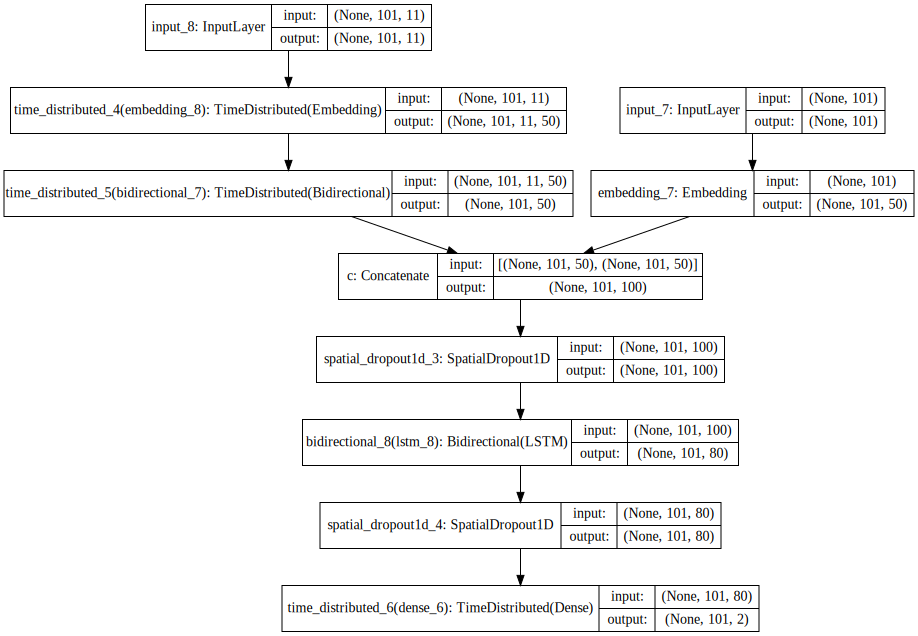

In [42]:
plot_keras_model(model)

In [39]:
model = preparation_elmo_v1(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 101)          0                                            
__________________________________________________________________________________________________
la (Lambda)                     (None, 101, 1024)    0           in[0][0]              

In [26]:
f1, train_f1s, test_f1s = preparation_elmo_v1(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 101)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 1024)    0           input_11[0][0]        

KeyboardInterrupt: 

In [131]:
f1

0.738095238095238

In [91]:
f1, train_f1s, test_f1s = preparation_elmo_v1(datasets[0], models[0].model)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 101)          0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 101, 1024)    0           input_32[0][0]        

386/386 [==============================] - 3801s 10s/step - loss: 0.0641 - acc: 0.9700 - val_loss: 0.0586 - val_acc: 0.9754
(52, 101, 1)
(54, 101)
0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
(52, 101)
(388, 101)
0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
54 56
56 58
58 60
60 62
62 64
64 66
66 68
68 70
70 72
72 74
74 76
76 78
78 80
80 82
82 84
84 86
86 88
88 90
90 92
92 94
94 96
96 98
98 100
100 102
102 104
104 106
106 108
108 110
110 112
112 114
114 116
116 118
118 120
120 122
122 124
124 126
126 128
128 130
130 132
132 134
134 136
136 138
138 140
140 142
142 144
144 146
146 148
148 150
150 152
152 154
154 156
156 158
158 160
160 162
162 164
164 166
166 168
168 170
170 172
172 174
174 176
176 178
178 180
180 182
182 184
184 186
186 188
188 190
190 192
192 194
194 196
196

2 4
4 6
6 8
8 10
10 12
12 14
14 16
16 18
18 20
20 22
22 24
24 26
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53


In [94]:
f1

0.7644444444444445

In [92]:
train_f1s

[0.5056751467710372, 0.7671852899575672]

In [93]:
test_f1s

[0.46537396121883656, 0.7445544554455444]

In [206]:
epochs = []
datatype = []
f1_scores = []
epochs = [epoch for epoch, f1 in enumerate(train_f1s, 1)]
epochs.extend(epochs)
datatype = ['train' for elem in train_f1s]
datatype.extend(['test' for elem in test_f1s])
f1_scores.extend(train_f1s.copy())
f1_scores.extend(test_f1s.copy())
evaluation = [{'F1-score' : result[0], 'epoch' : result[1],
                    'data' : result[2]} for result in zip(f1_scores, epochs, datatype)]
epochs_f1_scores = pd.DataFrame.from_records(evaluation)

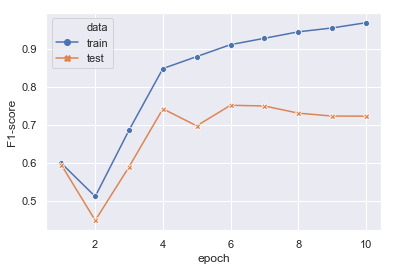

In [207]:
import seaborn as sns
sns.set()
ax = sns.lineplot(x="epoch", y="F1-score",
                   hue="data", style="data",
                   markers=True, dashes=False, data=epochs_f1_scores)
plt.show()

In [ ]:
sentence_lens = [len(sent) for sent in sentences]

Sentence lengths


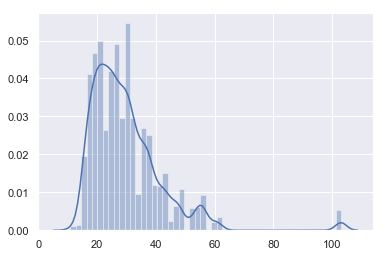

In [105]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
ax = sns.distplot(sentence_lens)
print('Sentence lengths')
plt.show()

In [453]:
figure = ax.get_figure()
figure.savefig('../plots/dl/sentence_length_dist.pdf')

In [196]:
len(metrics.f1_scores)

2

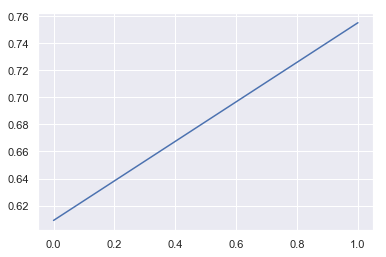

In [197]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

In [60]:
model = preparation_elmo_v1(datasets[0], \
                    models[0].model, model_v1_ElMo_residual_BiLSTM_h)

----------------------
# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
----------------------
# Sents train : 387
# Sents test : 53
# Sents dataset : 440
----------------------
# Words : 10722
# Vocab : 3639
# Words missing embedding : 160
Embedding shape : (3639, 50)
Max length sentence : 101
Training set length : 387
Test set length : 53
Training set length : 387
Test set length : 53
(386, 101, 1)
(52, 101, 1)
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
in (InputLayer)                 (None, 101)          0                                            
__________________________________________________________________________________________________
la (Lambda)                     (None, 101, 1024)    0           in[0][0]              